In [3]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
#os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=cuda*"
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import random, sys, keras
import pickle

from scipy.fft import fft, ifft

ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/wjyun/anaconda3/envs/ML/lib/python3.8/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/home/wjyun/anaconda3/envs/ML/lib/python3.8/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/home/wjyun/anaconda3/envs/ML/lib/python3.8/site-packages/theano/gpuarray/__init__.py", line 95, in init_dev
    context = pygpu.init(
  File "pygpu/gpuarray.pyx", line 658, in pygpu.gpuarray.init
  File "pygpu/gpuarray.pyx", line 569, in pygpu.gpuarray.pygpu_init
ValueError: invalid literal for int() with base 10: '*'


In [4]:
# Load the dataset ...
# You will need to seperately download or generate this file
with open("RML2016.10a_dict.dat",'rb') as f:
    Xd = pickle.load(f, encoding='latin1') # encoding 방식 추가해줘야 돌아감

snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

#snrs = [-4, -2, 0, 2, 4, 6, 8, 10, 12, 14]

X = []      
lbl = []
for mod in mods:
    for snr in snrs:
        X.append((Xd[(mod,snr)]))
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
X.shape


(220000, 2, 128)

In [5]:
print(np.shape(lbl))

(220000, 2)


In [32]:
Xd.keys()

dict_keys([('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('AM-SSB', 12), ('8PSK', 8), ('8PSK', 12), ('QAM64', -6), ('QAM16', 2), ('QAM16', -20), ('PAM4', -6), ('WBFM', -18), ('AM-DSB', 16), ('CPFSK', 10), ('WBFM', 6), ('BPSK', 4), ('BPSK', -2), ('QPSK', -20), ('CPFSK', -8), ('AM-SSB', 6), ('QAM64', -20), ('QAM16', 12), ('GFSK', -20), ('AM-SSB', -12), ('CPFSK', 0), ('AM-DSB', 6), ('BPSK', -16), ('QPSK', -6), ('8PSK', -12), ('CPFSK', -18), ('BPSK', -10), ('QPSK', 8), ('PAM4', 14), ('AM-DSB', -10), ('GFSK', 12), ('QAM64', 2), ('WBFM', -4), ('AM-SSB', -18), ('QAM64', -4), ('GFSK', -4), ('AM-DSB', 8), ('PAM4', -16), ('QPSK', -16), ('BPSK', 16), ('8PSK', -8), ('CPFSK', 16), ('WBFM', 0), ('QPSK', 6), ('BPSK', 14), ('AM-DSB', -8), ('GFSK', -10), ('CPFSK', -2), ('AM-SSB', 8), ('GFSK', 18), ('QAM16', 6), ('QAM16', -16), ('QAM64', 18), ('AM-SSB', -2), ('CPFSK', 6), ('BPSK', 0), ('BPSK', -6), ('8PSK', -14), ('CPFSK', -12), ('AM-SSB', 2), ('WBFM', 10), ('AM-DSB', -12), ('PAM4

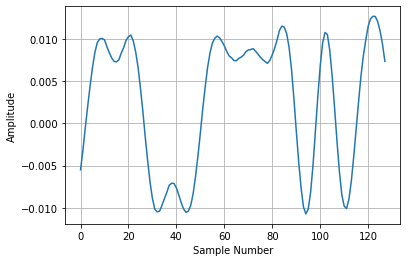

In [169]:
plt.plot(Xd[('BPSK',18)][3][1])
#plt.title('BPSK')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.grid(True)
plt.savefig('BPSK.png')

In [85]:
X

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127.])

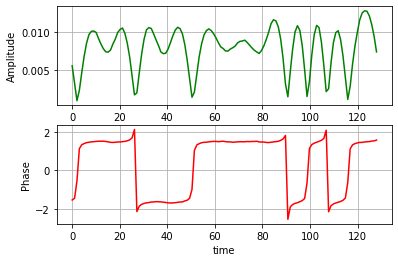

In [99]:
#complex(X[samp_num,0,column], X[samp_num,1,column
#X_com=[]
#print(Xd[('BPSK',18)][3][0])
#print(Xd[('BPSK',18)][3][1])
X_com = np.vectorize(complex)(Xd[('BPSK',18)][3][0], Xd[('BPSK',18)][3][1])
plt.subplot(2,1,1)
plt.plot(X, np.abs(X_com), '-g')
plt.xlabel('time')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(X, np.angle(X_com),'-r')
plt.xlabel('time')
plt.ylabel('Phase')
plt.grid(True)

plt.savefig('BPSK_ampPhase.png')

In [160]:
from scipy.fft import fft, ifft, fftshift
t = np.linspace((len(data)/2+1),128)
data = abs(fft(X_com))
flipdata = []
flipdata = np.hstack([data[65:len(data)] , data[1:64]])
                 #,data(1:len(data)/2)]

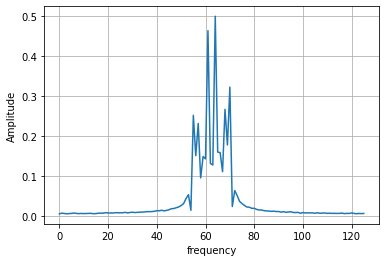

In [168]:
plt.plot(flipdata)
plt.xlabel('frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('BPSK_FFT2.png')

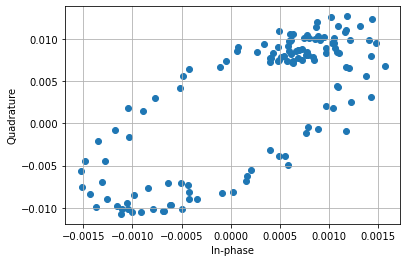

In [47]:
plt.scatter(Xd[('BPSK',18)][3][0], Xd[('BPSK',18)][3][1])
#plt.title('Q_samples')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.savefig('BPSK_scatter.png')

In [8]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    data = list(yy) # 값을 list에 넣어주는 코드가 없어서 추가했음
    yy1 = np.zeros([len(data), max(data)+1])
    yy1[np.arange(len(data)),data] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [9]:
lbl[0][0]

'8PSK'

In [10]:
print(np.shape(Y_train))
print(np.shape(X_train))

(110000, 11)
(110000, 2, 128)


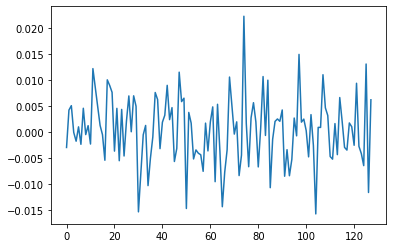

In [16]:
plt.plot((X_train[0][1]))

## Standardize the features

In [35]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
_X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1]*X_train.shape[2]])
_X_train = sc.fit_transform(_X_train)
X_train_std = np.reshape(_X_train, X_train.shape)

_X_test =  np.reshape(X_test, [X_test.shape[0], X_test.shape[1]*X_test.shape[2]])
_X_test = sc.transform(_X_test)
X_test_std = np.reshape(_X_test, X_test.shape)

print("Std Training set", X_train.shape)
print("Std Test set", X_test.shape)


Std Training set (110000, 2, 128)
Std Test set (110000, 2, 128)


In [36]:
print(X_test[0][0])
print(X_test_std[0][0])

[ 3.6192215e-03  4.1053700e-03  4.1872668e-03  2.0399359e-03
 -6.0896827e-03  6.0783592e-03  3.5174673e-03  2.8358048e-03
 -8.9330291e-03 -9.9450024e-04  1.6996209e-04  9.4088080e-04
 -3.1495197e-03  6.6490979e-03 -5.2884463e-03  3.3014307e-03
 -4.5615453e-03 -2.7553078e-03  1.7953458e-03 -3.3962231e-03
 -5.3859297e-03 -2.9340864e-03 -7.9219352e-04  1.5042312e-03
 -3.4970695e-03 -5.0159525e-03 -2.2609537e-03 -5.7104542e-03
  8.6483816e-03 -2.7257642e-03  1.3575920e-02 -1.8753997e-03
 -6.4968236e-04 -1.1087590e-02  3.6407907e-03 -6.7550666e-03
  1.9208334e-03  1.4192799e-02  6.0260869e-03  3.6928956e-03
 -2.0635307e-03  7.6597184e-03  8.3919405e-04  3.5975359e-03
  2.1965997e-03  1.8955189e-03  1.4922224e-03 -2.8048963e-03
  7.9404386e-03  1.0011346e-02 -3.5809862e-05 -2.6287772e-03
  6.9297856e-04 -4.0375534e-04 -3.9953366e-03 -2.3063815e-03
  2.5363585e-03  6.0648015e-03  1.2908622e-03  6.6205312e-04
  1.1069482e-03 -1.0274015e-02 -2.3181567e-03  2.1979911e-03
  1.0302558e-02  1.81248

In [57]:
# Build VT-CNN2 Neural Net model using Keras primitives --
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization
 
# Set up some params 
nb_epoch = 100        # number of epochs to train on
batch_size = 256  # training batch size
dr = 0.6 # dropout rate (%)
 
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, (1, 3), padding='valid', input_shape=in_shp, activation="relu", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, (1, 3), strides=1, padding="valid", input_shape=in_shp, activation="relu", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dr))
model.add(Dense( len(classes), kernel_initializer='he_normal'))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 1, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 4, 256)         98560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 4, 256)         0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 1, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 6, 80)          61520     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 6, 80)         

In [58]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
#weight written to jupyter directory (where notebook is). saved in hdf5 format.
 
#netron can open the h5 and show architecture of the neural network
#filepath = 'IQ_std_convmodrecnets_CNN2_0.5.wts.h5'
filepath = 'IQ_convmodrecnets_CNN2_0.5.wts.h5'
#filepath = 'IQ_std_convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        #params determine when to save weights to file. Happens periodically during fit.
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
"""
history_std = model.fit(X_train_std,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test_std, Y_test),
    callbacks = [
        #params determine when to save weights to file. Happens periodically during fit.
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
"""
# we re-load the best weights once training is finished. best means lowest loss values for test/validation
model.load_weights(filepath)

Epoch 1/100
430/430 - 8s - loss: 2.1360 - val_loss: 1.8758
Epoch 2/100
430/430 - 8s - loss: 1.8615 - val_loss: 1.7588
Epoch 3/100
430/430 - 7s - loss: 1.7709 - val_loss: 1.6687
Epoch 4/100
430/430 - 7s - loss: 1.7143 - val_loss: 1.6422
Epoch 5/100
430/430 - 7s - loss: 1.6869 - val_loss: 1.6240
Epoch 6/100
430/430 - 7s - loss: 1.6676 - val_loss: 1.6068
Epoch 7/100
430/430 - 7s - loss: 1.6529 - val_loss: 1.5930
Epoch 8/100
430/430 - 7s - loss: 1.6407 - val_loss: 1.5947
Epoch 9/100
430/430 - 7s - loss: 1.6304 - val_loss: 1.5823
Epoch 10/100
430/430 - 7s - loss: 1.6192 - val_loss: 1.5795
Epoch 11/100
430/430 - 7s - loss: 1.6130 - val_loss: 1.5649
Epoch 12/100
430/430 - 7s - loss: 1.6058 - val_loss: 1.5625
Epoch 13/100
430/430 - 7s - loss: 1.5973 - val_loss: 1.5503
Epoch 14/100
430/430 - 7s - loss: 1.5886 - val_loss: 1.5359
Epoch 15/100
430/430 - 7s - loss: 1.5790 - val_loss: 1.5322
Epoch 16/100
430/430 - 7s - loss: 1.5684 - val_loss: 1.5201
Epoch 17/100
430/430 - 7s - loss: 1.5624 - val_lo

In [1]:
filepath = 'IQ_convmodrecnets_CNN2_0.5.wts.h5'
model.load_weights(filepath)

NameError: name 'model' is not defined

## Evaluate and Plot Model Performance

In [67]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

2.619025230407715


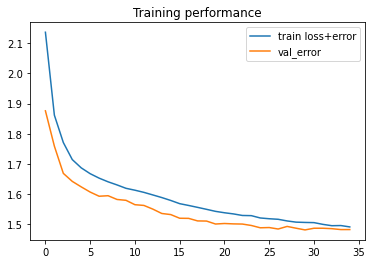

In [68]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()


In [43]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

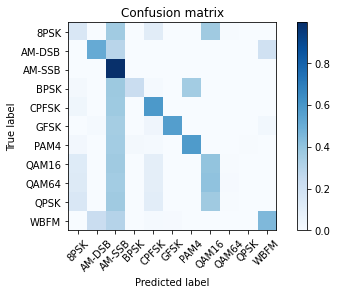

In [44]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test_std, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [45]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test_std[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    


Overall Accuracy:  0.09515096065873742
Overall Accuracy:  0.09336966394187103
Overall Accuracy:  0.098589001447178
Overall Accuracy:  0.0972573078311079
Overall Accuracy:  0.12196900638103919
Overall Accuracy:  0.1586991291985072
Overall Accuracy:  0.2612529854859453
Overall Accuracy:  0.38892961876832843
Overall Accuracy:  0.5044362292051756
Overall Accuracy:  0.5489840348330914
Overall Accuracy:  0.5797445255474453
Overall Accuracy:  0.6052344601962922
Overall Accuracy:  0.6196769456681351
Overall Accuracy:  0.6285198555956679
Overall Accuracy:  0.6236248872858431
Overall Accuracy:  0.6222222222222222
Overall Accuracy:  0.6255658156798841
Overall Accuracy:  0.635357076951467
Overall Accuracy:  0.6257013574660634
Overall Accuracy:  0.6286228622862287


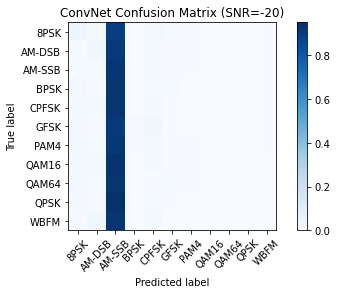

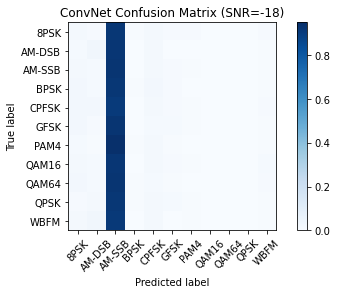

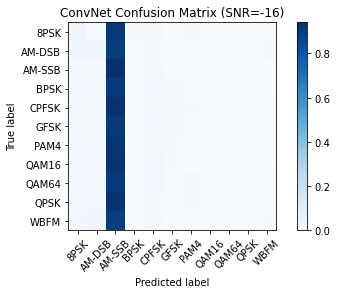

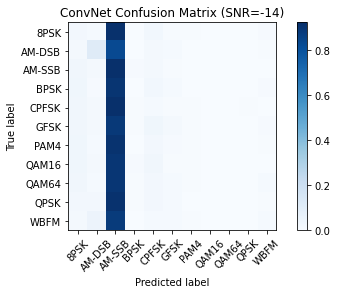

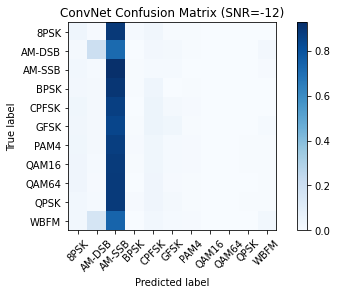

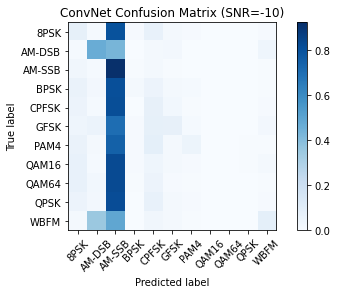

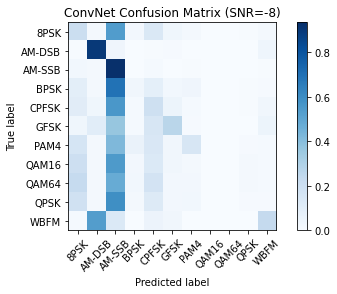

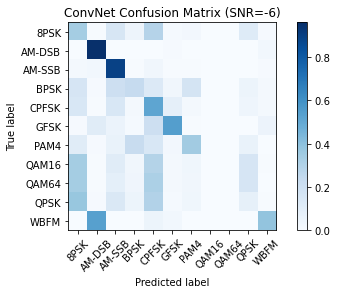

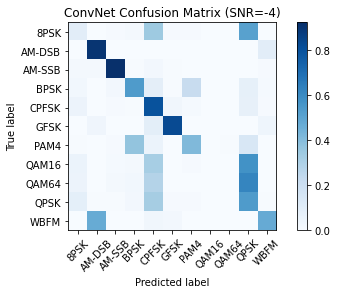

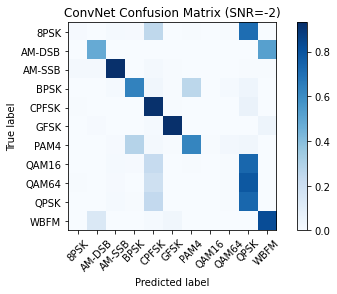

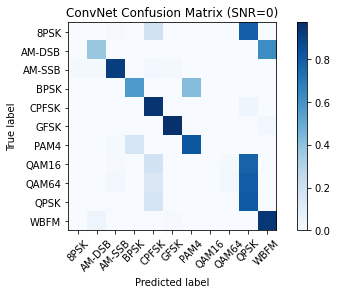

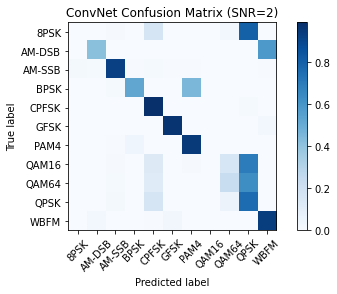

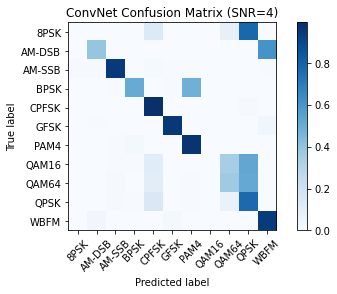

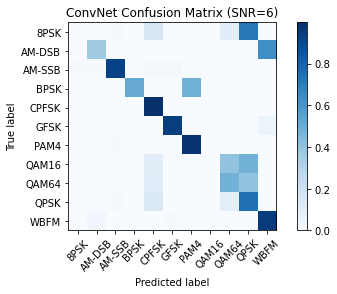

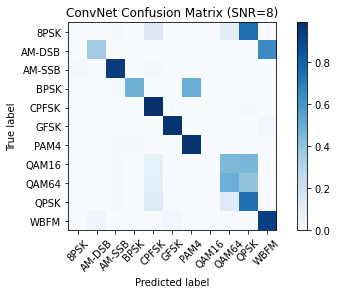

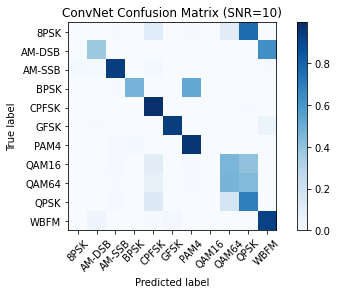

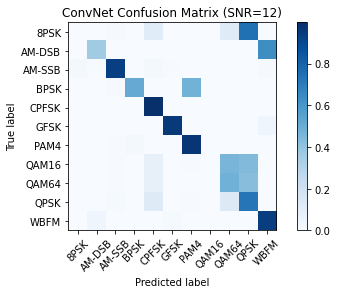

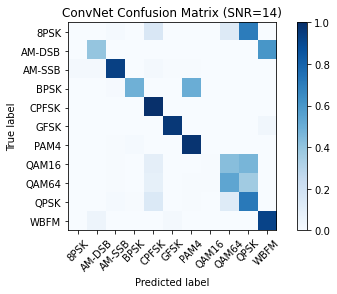

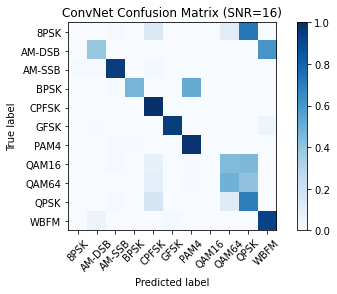

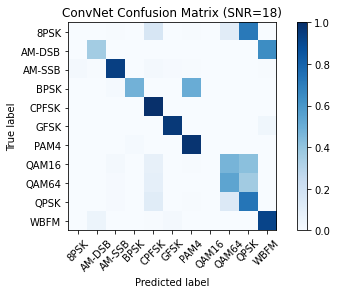

In [78]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    #test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)



In [79]:
import _pickle as cPickle
# Save results to a pickle file for plotting later
print(acc)
fd = open('IQ_results_cnn2_d0.5.dat','wb')
#fd = open('IQ_results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{-20: 0.09515096065873742, -18: 0.09336966394187103, -16: 0.098589001447178, -14: 0.0972573078311079, -12: 0.12196900638103919, -10: 0.1586991291985072, -8: 0.2612529854859453, -6: 0.38892961876832843, -4: 0.5044362292051756, -2: 0.5489840348330914, 0: 0.5797445255474453, 2: 0.6052344601962922, 4: 0.6196769456681351, 6: 0.6285198555956679, 8: 0.6236248872858431, 10: 0.6222222222222222, 12: 0.6255658156798841, 14: 0.635357076951467, 16: 0.6257013574660634, 18: 0.6286228622862287}


Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

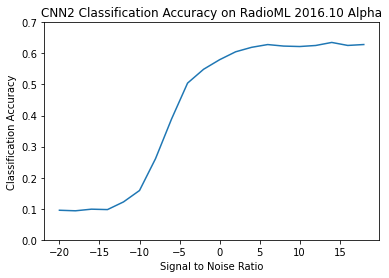

In [80]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.ylim(0, 0.7)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")